In [32]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [167]:
from pathlib import Path
from get_train_test_1 import split_train_test
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import cv2

# Creation of the data

## Creation of files train-val and test - Sentinel (data_HR)

In [168]:

# change the data path here
data_HR_path= Path('data_HR') 
images_path=str(data_HR_path/'data'/'images')

#Names to the files
train_val_file='train_val_2'
test_file='test_2'
percent_test=0.10 #10%

In [169]:
split_train_test(original_dataset_dir= images_path, 
                 base_dir = str(data_HR_path),
                 test_split = percent_test, 
                 train_file=train_val_file,
                 test_file=test_file)

7670 6903 767
data_HR/train_val_2/images
data_HR/test_2/images


## Creation of files train-val and test - Sentinel (data_HR)

In [170]:
# change the data path here
data_HR_path= Path('data_VHR') 
images_path=str(data_HR_path/'data'/'images')

#Names to the files
train_val_file='train_val_850_2'
test_file='test_850_2'
percent_test=0.10 #10%

split_train_test(original_dataset_dir= images_path, 
                 base_dir = str(data_HR_path),
                 test_split = percent_test, 
                 train_file=train_val_file,
                 test_file=test_file)

# Plot  images + mask

In [181]:
def mask_overlay(image, mask, color=(15, 15, 0)):
    """
    Helper function to visualize mask over the img
    """
    print(mask.shape)      
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    mask = mask.astype(np.float32)
    weighted_sum = cv2.addWeighted(mask, 0.3, image, 0.7, 0.)
    img = image.copy()
    ind = mask[:, :, 0] > 0  
    img[ind] = weighted_sum[ind]

    return img

def plot_img_mask(img_path,source='satellite'):
    img = np.load(str(img_path))
    if source=='satellite':
        img=img.transpose(1,2,0)
    print(np.shape(img),np.min(img),np.max(img))

    img2 = (img[:,:,:3].astype(np.float32))/np.max(img)
    #inp = (img*255).astype(np.uint8)
    mask = np.load(str(img_path).replace('images', 'masks').replace(r'.npy', r'_a.npy'), 0)
    mask=mask.transpose(1, 2, 0).reshape(mask.shape[1],-1)
    mask=(mask > 0).astype(np.float32)

    fig = plt.figure(figsize=(30, 30))  
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    ax1=plt.subplot(131)
    ax1.imshow(img2)
    ax2=plt.subplot(132)
    ax2.imshow(mask)

    ax3=plt.subplot(133)
    ax3.imshow(mask_overlay(img2, mask))


## PeruSat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 4) 84 1245
(512, 512)


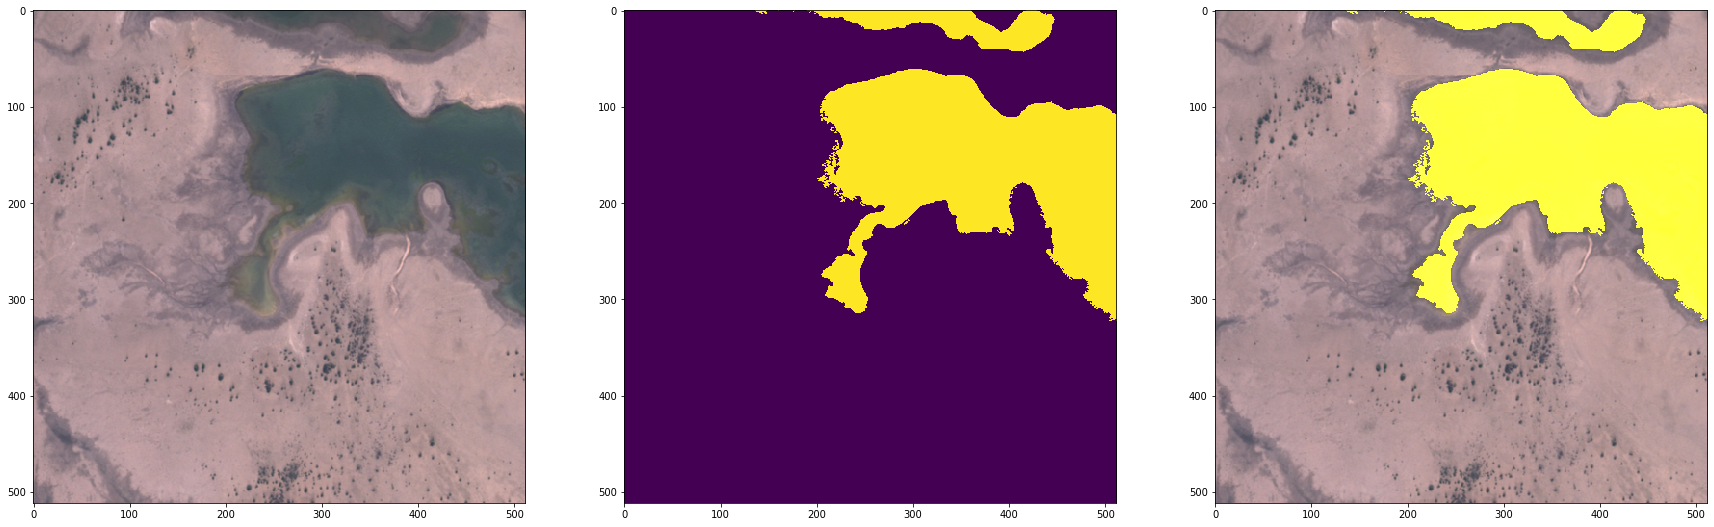

In [173]:
img_path ="data_VHR/train_val_850/images/rgbnir23072-3072.npy"
plot_img_mask(img_path)


## Sentinel

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 4) 0.04019999876618385 0.3898000121116638
(64, 64)


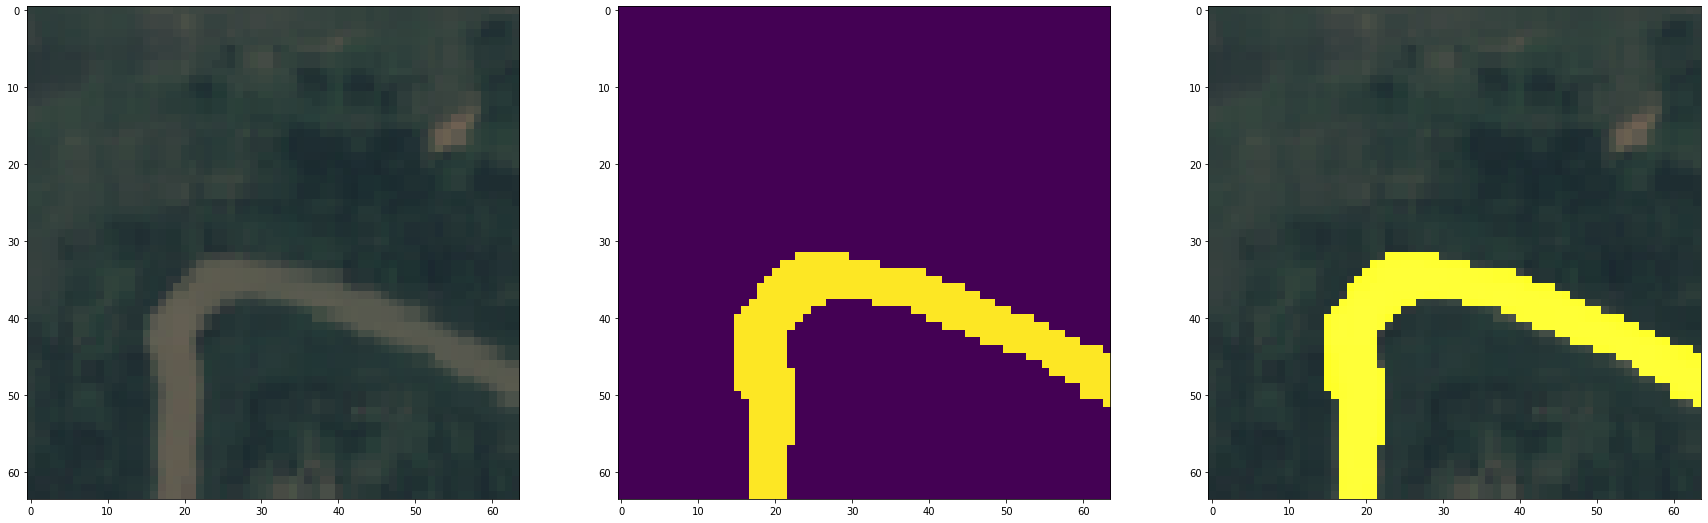

In [159]:
img_path ="data_HR/test_HR/images/rgbnir7585.npy"
plot_img_mask(img_path)

# Run the model

In [175]:
# change the data path here
data_path= Path('data_corn_160') 
images_path=str(data_HR_path/'data'/'images')

#Names to the files
train_val_file='train_val_corn'
test_file='test_corn'
percent_test=0.10 #10%

split_train_test(original_dataset_dir= images_path, 
                 base_dir = str(data_HR_path),
                 test_split = percent_test, 
                 train_file=train_val_file,
                 test_file=test_file)

27474 24727 2747
data_corn_160/train_val_corn/images
data_corn_160/test_corn/images


In [197]:
import glob  ###
import os
from get_train_test_kfold import get_split_out, percent_split, get_split_in
from scalarmeanstd import meanstd

data_path= Path('data_VHR') 
train_val_file='train_val_850'
test_file='test_850'
input_channels=4
train_val_file_names=np.array(sorted(glob.glob(str(data_path/train_val_file/'images')+ "/*.npy")))
test_file_names =  np.array(sorted(glob.glob(str(data_path/test_file/'images') + "/*.npy")))
    
train_file_names,val_file_names = get_split_in(train_val_file_names,0)
max_values, mean_values, std_values=meanstd(train_file_names, val_file_names,test_file_names,str(data_path),input_channels) #_60 
print(max_values, mean_values, std_values)


elapsed time: 4.729209679178894
Train: data_VHR 680 min  0 max  3521
mean:[0.11555246 0.10432396 0.1150794  0.14246734]
std:[0.08946183 0.06699049 0.05742599 0.11001556]
Val: data_VHR 171 min  0 max  3413
mean:[0.11037574 0.10181481 0.11340307 0.13146787]
std:[0.09269447 0.07017382 0.06007207 0.11270477]
Test: data_VHR 94 -min  0 max  3270
mean:[0.10769105 0.09666061 0.10785635 0.13395942]
std:[0.08557147 0.06195216 0.05175427 0.11169893]
All: data_VHR 945 min  0 max  3521
mean:[0.11383374 0.10310764 0.11405758 0.13963067]
std:[0.08972336 0.06713878 0.05742005 0.11076992]
3521 [0.11555246 0.10432396 0.1150794  0.14246734] [0.08946183 0.06699049 0.05742599 0.11001556]


27474

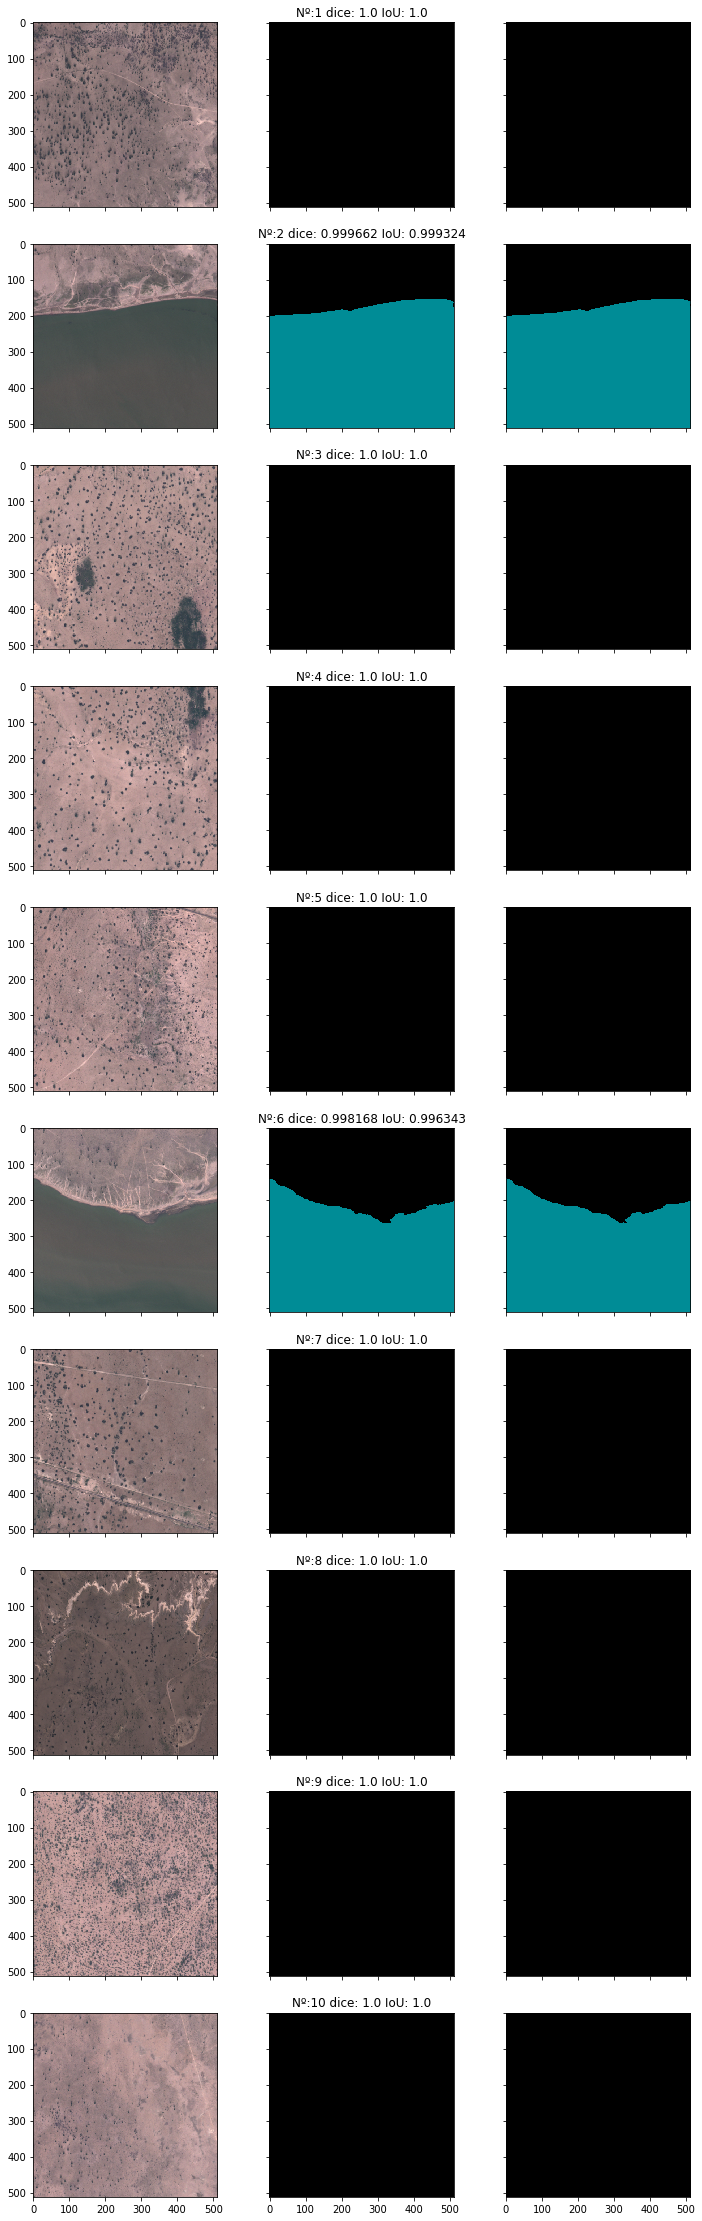

In [213]:
import helper 
loss_file = open("predictions_VHR/pred_loss_test_100_percent_UNet11_foldout0_foldin4.txt")#pred_loss_test_100_percent_VHR_UNet11_foldout0_foldin0_1epochs.txt")

filedata = loss_file.read()
filedata = filedata.replace("bce",",bce")
filedata = filedata.split(",")

val_file = "predictions_VHR/inputs_test_100_percent_94_UNet11_fold0.npy"#inputs_test_100_percent_VHR_UNet11_foldout0_foldin0_1epochs_94.npy"
pred_file = "predictions_VHR/pred_test_100_percent_94_UNet11_fold0.npy"#pred_test_100_percent_VHR_UNet11_foldout0_foldin0_1epochs_94.npy"
label_file = "predictions_VHR/labels_test_100_percent_94_UNet11_fold0.npy"#labels_test_100_percent_VHR_UNet11_foldout0_foldin0_1epochs_94.npy"

val_images = np.load(val_file)
pred_images = np.load(pred_file)
val_label = np.load(label_file)
pred_images[0,0,:,:,:].shape

name_output=("test_100_percent_UNet11_foldout0_foldin0_1epochs")
input_images_rgb = [helper.reverse_transform(x) for x in val_images[:10,0,:3,:,:]]   #new metrics
# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in val_label[:10,0,:3,:,:]]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred_images[:10,0,:,:,:]]
#print(np.shape(input_images_rgb))
#print(len([input_images_rgb, target_masks_rgb, pred_rgb]))
out_file='VHR'
# stage + name_file + name_model+'_foldin' +str(fold_in)
helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb],filedata, out_file, name_output, save=1)
    

In [214]:
val_images[1,0,:3,:,:]

array([[[1.7243202 , 1.7368212 , 1.8055754 , ..., 2.189975  ,
         2.0837183 , 1.9805866 ],
        [1.733696  , 1.7836992 , 1.8680794 , ..., 2.0368404 ,
         2.0618417 , 1.9493346 ],
        [1.733696  , 1.7836992 , 1.8337024 , ..., 1.9993379 ,
         2.0868433 , 2.018089  ],
        ...,
        [0.22109954, 0.21172391, 0.22422464, ..., 0.2429759 ,
         0.23985064, 0.2273499 ],
        [0.2273499 , 0.20234828, 0.21484901, ..., 0.26485226,
         0.2711026 , 0.21172391],
        [0.18984756, 0.1867223 , 0.20234828, ..., 0.23672554,
         0.24922626, 0.24922626]],

       [[1.8198924 , 1.8739793 , 1.8739793 , ..., 2.3399603 ,
         2.2692308 , 2.1735387 ],
        [1.8074107 , 1.8448557 , 1.9072638 , ..., 2.1818595 ,
         2.2193046 , 2.086167  ],
        [1.8531767 , 1.8531767 , 1.9072638 , ..., 2.177699  ,
         2.2442675 , 2.0736854 ],
        ...,
        [0.4801976 , 0.513482  , 0.49267927, ..., 0.5176424 ,
         0.54676634, 0.5010003 ],
        [0.4

In [211]:
val_images[1,0,:3,:,:]

array([[[ 99196.15 ,  99611.2  , 101893.984, ..., 114656.805,
         111128.87 , 107704.695],
        [ 99507.44 , 101167.64 , 103969.234, ..., 109572.43 ,
         110402.53 , 106667.07 ],
        [ 99507.44 , 101167.64 , 102827.84 , ..., 108327.27 ,
         111232.63 , 108949.85 ],
        ...,
        [ 49286.254,  48974.965,  49390.016, ...,  50012.594,
          49908.83 ,  49493.777],
        [ 49493.777,  48663.676,  49078.727, ...,  50738.934,
          50946.457,  48974.965],
        [ 48248.625,  48144.863,  48663.676, ...,  49805.066,
          50220.117,  50220.117]],

       [[118886.45 , 120808.766, 120808.766, ..., 137370.2  ,
         134856.42 , 131455.4  ],
        [118442.84 , 119773.67 , 121991.72 , ..., 131751.14 ,
         133081.98 , 128350.13 ],
        [120069.414, 120069.414, 121991.72 , ..., 131603.28 ,
         133969.2  , 127906.52 ],
        ...,
        [ 71272.29 ,  72455.25 ,  71715.91 , ...,  72603.125,
          73638.21 ,  72011.64 ],
        [ 71

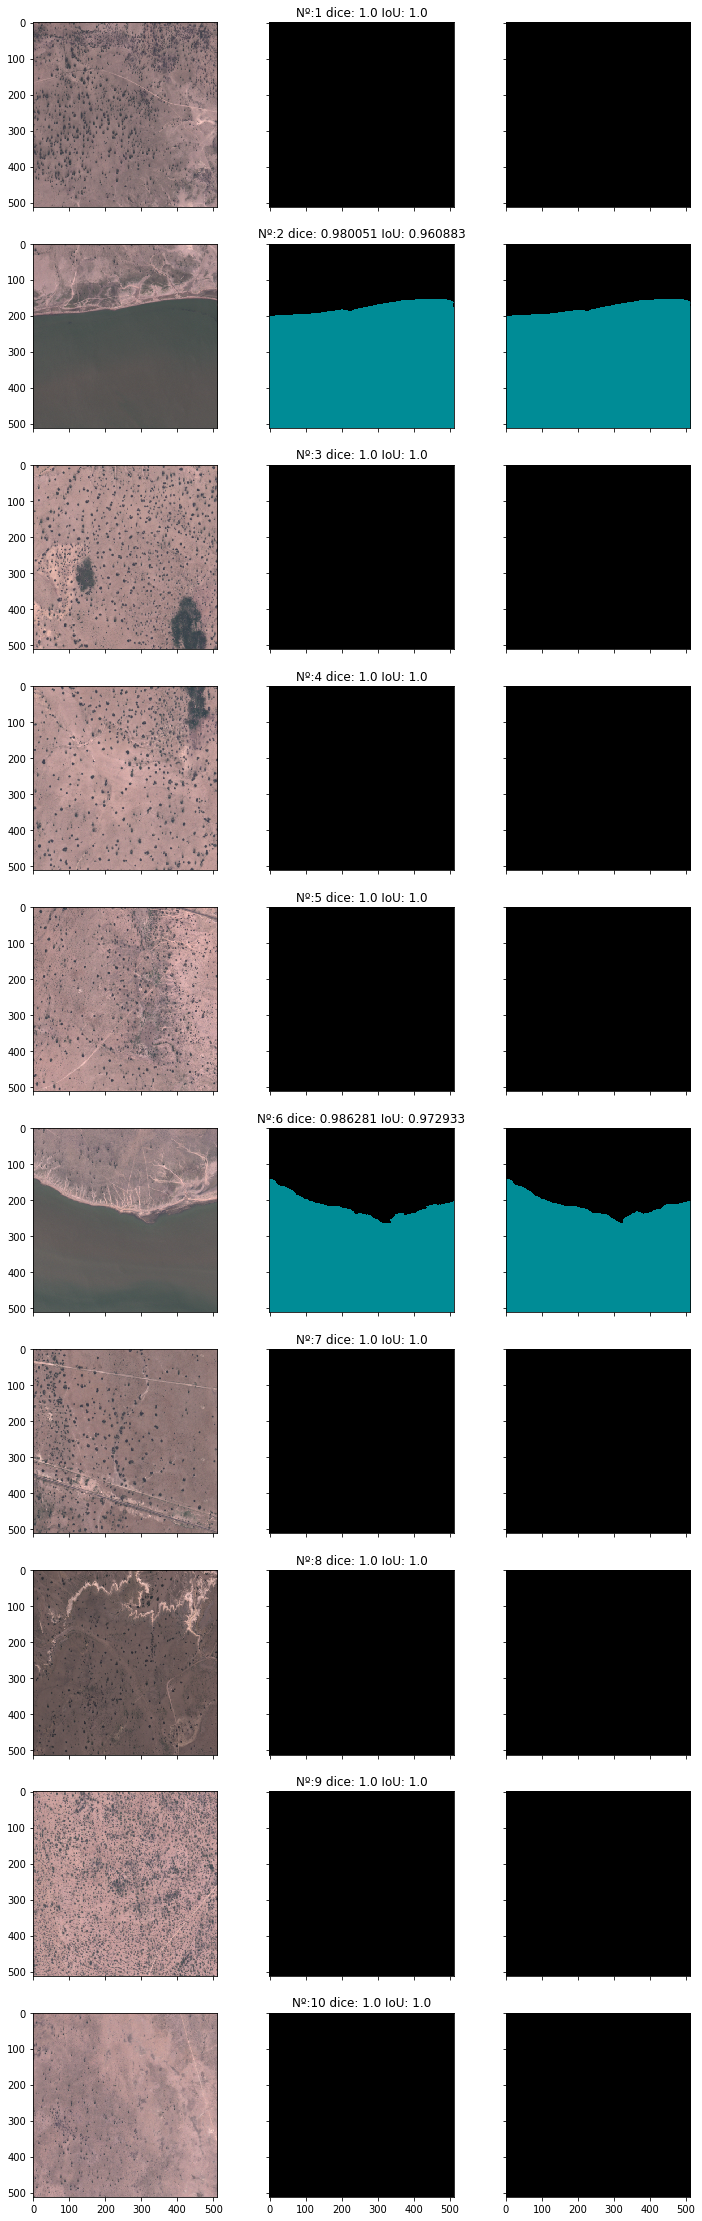

In [226]:
import helper 
loss_file = open("predictions_VHR/pred_loss_test_8_percent_VHR_UNet11_foldout0_foldin0_1epochs.txt")

filedata = loss_file.read()
filedata = filedata.replace("bce",",bce")
filedata = filedata.split(",")

val_file = "predictions_VHR/inputs_test_8_percent_94_UNet11_fold0.npy"#inputs_test_100_percent_VHR_UNet11_foldout0_foldin0_1epochs_94.npy"
pred_file = "predictions_VHR/pred_test_8_percent_94_UNet11_fold0.npy"#pred_test_100_percent_VHR_UNet11_foldout0_foldin0_1epochs_94.npy"
label_file = "predictions_VHR/labels_test_8_percent_94_UNet11_fold0.npy"#labels_test_100_percent_VHR_UNet11_foldout0_foldin0_1epochs_94.npy"

val_images = np.load(val_file)
pred_images = np.load(pred_file)
val_label = np.load(label_file)
pred_images[0,0,:,:,:].shape

name_output=("test_100_percent_UNet11_foldout0_foldin0_1epochs_x")
input_images_rgb = [helper.reverse_transform(x) for x in val_images[:10,0,:3,:,:]]   #new metrics
# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in val_label[:10,0,:3,:,:]]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred_images[:10,0,:,:,:]]
#print(np.shape(input_images_rgb))
#print(len([input_images_rgb, target_masks_rgb, pred_rgb]))
out_file='VHR'
# stage + name_file + name_model+'_foldin' +str(fold_in)
helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb],filedata, out_file, name_output, save=1)
    

In [227]:
val_images[1,0,:3,:,:]

array([[[1.6875771 , 1.6992941 , 1.7637358 , ..., 2.1240244 ,
         2.0244327 , 1.9277695 ],
        [1.6963648 , 1.7432317 , 1.8223193 , ..., 1.980495  ,
         2.0039282 , 1.8984778 ],
        [1.6963648 , 1.7432317 , 1.7900985 , ..., 1.9453447 ,
         2.0273614 , 1.9629198 ],
        ...,
        [0.2786438 , 0.2698562 , 0.28157288, ..., 0.29914796,
         0.29621875, 0.2845021 ],
        [0.2845021 , 0.26106867, 0.2727853 , ..., 0.31965217,
         0.32551047, 0.2698562 ],
        [0.24935202, 0.2464228 , 0.26106867, ..., 0.29328966,
         0.3050063 , 0.3050063 ]],

       [[1.7342948 , 1.7844408 , 1.7844408 , ..., 2.216467  ,
         2.1508913 , 2.062172  ],
        [1.7227226 , 1.7574391 , 1.8152997 , ..., 2.0698864 ,
         2.104603  , 1.981167  ],
        [1.7651539 , 1.7651539 , 1.8152997 , ..., 2.0660293 ,
         2.127747  , 1.9695947 ],
        ...,
        [0.49222007, 0.5230791 , 0.5037922 , ..., 0.52693635,
         0.55393815, 0.511507  ],
        [0.4